# Analysis of Purchase Data

Let's take a look at purchase data from some e-commerce companies

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.stats import chi2_contingency, beta, lognorm, norm, invgamma
from IPython.display import Image
import numpy as np


In [2]:
data=pd.read_csv('Order Details.csv')

In [3]:
data.dropna(subset=['Amount'], inplace=True)  # Modifies original data


<Axes: ylabel='Frequency'>

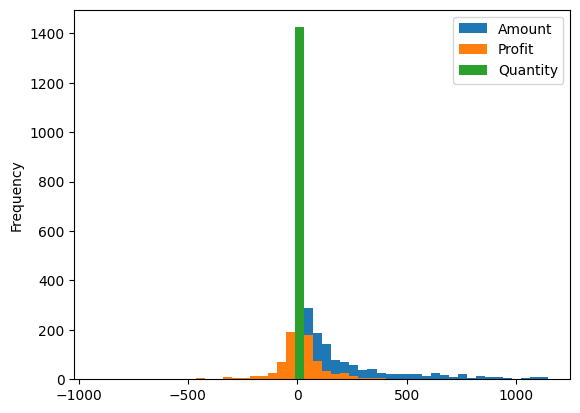

In [6]:
data['Amount'] = pd.to_numeric(data['Amount'], errors='coerce')  # Coerce non-numeric to NaNs
quantile = data['Amount'].quantile(0.95)
filtered_data = data[data['Amount'] < quantile]
filtered_data.plot.hist(bins=50)

In [5]:
data['Amount'] = pd.to_numeric(data['Amount'], errors='coerce')  # Coerce non-numeric to NaNs
prices = data['Amount'][(data['Amount'] < data.quantile(0.95)['Amount']) & (data['Amount'] > 0)]
np.log(prices).plot.hist(bins=50)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [7]:
data['Amount'].dtypes

dtype('float64')

In [8]:
data['Amount'] = pd.to_numeric(data['Amount'], errors='coerce')

In [9]:
quantile = data['Amount'].quantile(0.95)

In [10]:
prices = data['Amount'][(data['Amount'] < quantile) & (data['Amount'] > 0)]

<Axes: ylabel='Frequency'>

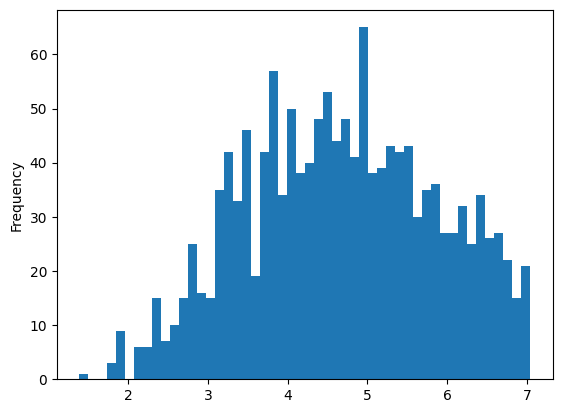

In [13]:
np.log(prices).plot.hist(bins=50)

In both cases, purchase data can be modeled by a log normal distribution. A lot of prices are low, a few prices are high.The log of these prices follow a normal distribution for most part

## Create Distributions


In [19]:
data=pd.read_csv('Order Details.csv')
data['price']=data['Amount']


In [24]:
data['price']=data['price'].astype(float)

In [25]:
data['price'].dtype


dtype('float64')

In [27]:
data['price'] = pd.to_numeric(data['price'])

In [32]:
data=data.reset_index().drop('index', axis=1)
sigma, loc, scale = lognorm.fit(data['price'], floc=0)
control_price_sampler=lognorm(sigma, loc, scale)

In [33]:
sigma, loc, scale

(1.3183368820362833, 0, 123.65978815562029)

<Axes: ylabel='Frequency'>

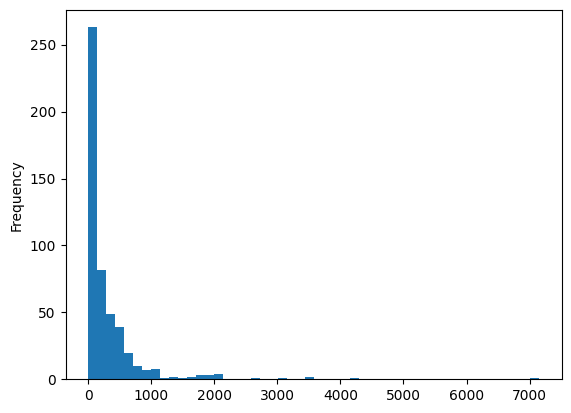

In [34]:
pd.Series(control_price_sampler.rvs(500)).plot.hist(bins=50)

In [35]:
price_change_distribution=norm(loc=25, scale=5)
price_changes=price_change_distribution.rvs(data['price'].shape[0])
treatment_prices=data['price'] + pd.Series(price_changes)
treatment_prices=treatment_prices[treatment_prices > 0]

In [36]:
sigma, loc, scale =lognorm.fit(treatment_prices, floc=0)
treatment_price_sampler=lognorm(sigma, loc, scale)

In [37]:
sigma, loc, scale

(1.0583339339654594, 0, 167.18506866553662)

<Axes: ylabel='Frequency'>

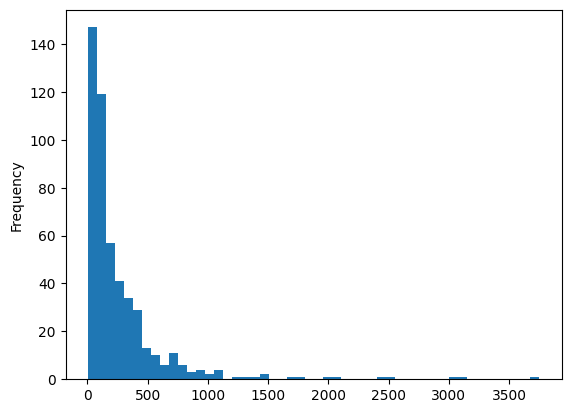

In [38]:
pd.Series(treatment_price_sampler.rvs(500)).plot.hist(bins=50)

**Create** **Dataset**

In [49]:
df=pd.read_csv('ab_data.csv')

## Remove users exposed to both groups
counter=df['user_id'].value_counts()
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df=df.merge(valid_users, on=['user_id'])
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])

## Get stats
start_time=datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time=datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration=(end_time-start_time).days

print(f"Number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")
print(f"Percentage of users in control: {round(df[df['group']=='control'].shape[0]*100/df.shape[0])}%")


Number of unique users in experiment: 286690
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']
Percentage of users in control: 50%


Generate prices using the 2 lognormal distributions we created

In [50]:
def get_purchase_data(exposure):
  if exposure['group'] == 'treatment':
    return treatment_price_sampler.rvs()
  return control_price_sampler.rvs()

df['price']=df.apply(get_purchase_data,axis=1).astype(int)
df=df[df['price']>0]

In [51]:
df.sample(2)

,user_id,timestamp,group,landing_page,converted,week,price
75492,904143,2017-01-17 22:00:19.673331,treatment,new_page,0,3,29
23793,727125,2017-01-08 07:38:06.340440,control,old_page,0,1,1484


In [52]:
df.to_csv("price_company.csv")

In [53]:
def draw_mus_and_sigmas(data, m0, k0, s_sq0, v0, n_samples=10000):
    """
    Sample mus (list) and sigma_squares (list) that are effectively
    sampled from the posterior normal distribtution
    """

    N = np.size(data) # number of samples
    the_mean = np.mean(data) # find the mean of the data
    SSD = sum( (data - the_mean)**2 ) # sum of squared differences between data and mean

    # 1) Sample the variances from an inverse gamma (params: alpha, beta)
    kN = float(k0 + N)
    mN = (k0/kN)*m0 + (N/kN)*the_mean
    vN = v0 + N
    vN_times_s_sqN = v0*s_sq0 + SSD + (N*k0*(m0-the_mean)**2)/kN
    alpha = vN/2
    beta = vN_times_s_sqN/2

    # NOTE: if X ~ inv-gamma(a,1) then b*X ~ inv-gamma(a,b)
    sig_sq_samples = beta*invgamma.rvs(alpha,size=n_samples)

    # 2) Sample means from a normal conditioned on the drawn sigmas (params: mean_norm, var_norm)
    mean_norm = mN
    var_norm = np.sqrt(sig_sq_samples/kN)
    mu_samples = norm.rvs(mean_norm,scale=var_norm,size=n_samples)

    # 3) return the mu_samples and sig_sq_samples
    return mu_samples, sig_sq_samples

In [54]:
def draw_log_normal_means(data, m0, k0, s_sq0, v0, n_samples):
    normal_data = np.log(data)
    mu_samples, sig_sq_samples = draw_mus_and_sigmas(normal_data, m0, k0, s_sq0, v0, n_samples)
    log_normal_mu_samples = np.exp(mu_samples + sig_sq_samples/2)
    return log_normal_mu_samples

In [55]:
NUM_WEEKS=3
prior=df[(df['group'] == 'control') & (df['week']==1)]
experiment=df[(df['week']>1) & (df['week']<=NUM_WEEKS)]


In [56]:
# Define priors (sell thru)
prior_samples=[prior['converted'].sample(1000).mean() for i in range(1000)]
prior_alpha, prior_beta,_,_=beta.fit(prior_samples, floc=0, fscale=1)

In [62]:
prior_conversions = prior_conversions.apply(pd.to_numeric, errors='coerce')

In [64]:
# Define priors (prices)
prior_conversions = prior[prior['converted']==1]
prior_samples = [prior_conversions.sample(1000).mean() for i in range(1000)]
prior_sigma, prior_loc, prior_scale = lognorm.fit(prior_samples, floc=0)

TypeError: Could not convert ['2017-01-04 02:02:29.6524652017-01-05 22:03:33.3617622017-01-04 13:56:20.8217542017-01-02 17:26:02.7515832017-01-05 08:03:15.1354382017-01-03 12:03:59.7657192017-01-07 05:02:50.5795082017-01-08 10:44:46.5092072017-01-07 03:46:19.3649592017-01-08 20:12:08.7670742017-01-08 13:31:32.4975842017-01-08 02:11:51.3836622017-01-05 08:41:49.8639212017-01-07 07:20:29.4679322017-01-08 10:55:40.1700242017-01-07 22:15:22.4712552017-01-07 06:01:45.0772142017-01-03 11:37:12.1858792017-01-05 08:53:34.9950902017-01-03 21:36:20.3471302017-01-02 20:45:52.8072442017-01-02 23:57:05.7274852017-01-05 06:54:35.8215002017-01-08 16:00:44.7350892017-01-06 22:16:53.4170092017-01-08 15:59:17.4395422017-01-08 15:43:26.6090992017-01-08 19:56:25.2693712017-01-05 11:49:19.9739372017-01-03 12:54:56.3635282017-01-03 14:42:34.5178422017-01-02 18:51:26.8097602017-01-03 12:29:38.2343532017-01-05 11:40:15.6990632017-01-04 08:04:46.8613022017-01-06 19:57:12.5932212017-01-02 22:26:42.8334922017-01-06 00:20:24.4484422017-01-02 16:07:27.6235842017-01-07 09:48:10.9650412017-01-07 11:22:16.6959042017-01-03 13:31:18.5437352017-01-04 05:09:11.5502302017-01-07 13:11:38.6639132017-01-06 21:38:00.9086922017-01-08 05:25:24.2701232017-01-07 08:09:14.7815232017-01-04 01:08:00.4178322017-01-08 15:19:58.8770722017-01-03 00:03:43.5140092017-01-03 01:26:55.7226312017-01-07 17:01:54.9253732017-01-06 05:27:58.2232582017-01-06 05:05:28.5368392017-01-08 17:54:27.3044292017-01-04 15:24:41.8152292017-01-04 04:09:47.0268582017-01-08 13:05:25.6662312017-01-04 15:25:59.8591262017-01-04 23:49:33.3687272017-01-05 10:58:26.8680302017-01-07 02:55:49.4092542017-01-04 13:33:02.4034142017-01-06 08:10:52.1176922017-01-06 16:45:57.1140232017-01-04 22:29:24.1585712017-01-02 14:07:13.0757902017-01-03 20:53:23.8037972017-01-03 11:06:23.4502712017-01-07 11:44:07.4715272017-01-06 11:15:41.6367392017-01-08 00:50:44.7313822017-01-05 15:39:19.5097052017-01-03 03:31:24.2174302017-01-07 20:41:34.0484002017-01-06 10:54:58.7119652017-01-07 13:07:14.6689562017-01-07 07:40:12.1906632017-01-07 09:13:30.7216822017-01-07 23:16:06.4589382017-01-05 06:54:52.1024872017-01-07 19:12:44.8462812017-01-07 06:24:21.0431582017-01-04 00:59:54.2835932017-01-03 19:17:55.9005172017-01-04 06:09:27.4342592017-01-04 09:22:37.1033702017-01-07 21:15:06.8695422017-01-07 18:52:51.3466772017-01-05 07:15:44.4550872017-01-02 22:09:02.2771632017-01-02 15:43:55.2894482017-01-07 10:30:12.2311642017-01-08 03:58:39.2207942017-01-05 15:58:50.1900092017-01-02 21:56:44.6539072017-01-07 07:33:03.7800432017-01-08 20:51:29.3669072017-01-03 11:10:19.2340332017-01-07 14:18:59.6276762017-01-04 13:27:13.0250982017-01-07 01:37:15.5179302017-01-07 08:42:07.3140602017-01-03 08:51:15.0622252017-01-07 17:27:29.8427812017-01-03 05:05:20.3387532017-01-03 02:18:27.0405172017-01-05 17:42:41.3885422017-01-08 14:47:03.8193182017-01-05 00:48:03.7188742017-01-03 02:47:15.4194742017-01-04 14:51:11.7970342017-01-03 16:04:46.6598072017-01-02 19:16:21.1707062017-01-05 11:55:50.8087012017-01-04 04:43:12.2890592017-01-06 06:11:55.7448962017-01-04 14:58:33.7216352017-01-04 07:25:57.3204732017-01-08 03:13:21.1947142017-01-03 23:33:30.5966992017-01-06 06:56:31.8696412017-01-08 04:05:44.2206812017-01-07 08:11:11.7944182017-01-06 02:18:30.8308802017-01-04 10:42:59.7358592017-01-04 14:57:42.8250672017-01-07 11:04:53.0298922017-01-06 10:34:45.1814462017-01-08 06:14:41.8214282017-01-05 06:43:52.7646812017-01-04 19:02:33.3372592017-01-03 09:34:42.8064542017-01-02 19:04:13.9727802017-01-03 16:28:11.7445002017-01-05 15:57:35.8103692017-01-08 22:27:09.9006962017-01-07 00:49:51.9608222017-01-03 05:33:36.3471862017-01-04 05:28:04.3128992017-01-02 18:34:54.5928932017-01-08 19:22:03.7430092017-01-03 17:02:52.9711972017-01-07 15:02:11.8897912017-01-05 23:44:50.5903262017-01-03 07:02:08.7018802017-01-06 11:04:42.5854252017-01-02 23:39:09.2230542017-01-07 04:18:34.1963452017-01-05 14:05:29.9249422017-01-02 14:54:21.0834352017-01-05 11:22:22.3210502017-01-06 14:13:44.1881062017-01-08 21:04:42.6370692017-01-05 23:29:18.8342972017-01-03 14:26:54.1976612017-01-04 16:08:18.1376062017-01-05 18:52:10.5828382017-01-06 16:03:33.2721122017-01-05 19:39:21.1584672017-01-04 08:23:31.4400082017-01-05 19:37:54.4794652017-01-06 01:37:30.3270812017-01-08 20:01:28.8917052017-01-05 17:48:16.1706172017-01-06 01:14:57.2274492017-01-04 06:59:42.3565852017-01-02 21:11:17.0677752017-01-06 20:22:45.3774362017-01-07 14:46:30.6074122017-01-04 15:07:49.7974832017-01-04 19:32:45.1896332017-01-02 21:03:19.3245492017-01-05 21:28:14.7805462017-01-03 20:58:05.0458392017-01-04 03:23:59.8109572017-01-07 08:19:26.0412012017-01-06 01:51:59.6954662017-01-05 08:49:11.5719432017-01-07 01:04:18.0572842017-01-05 07:56:06.6452692017-01-04 19:06:06.4138632017-01-08 12:02:17.1836352017-01-03 12:40:46.7198132017-01-03 14:15:18.5262962017-01-06 22:23:55.0743352017-01-04 12:29:24.1438182017-01-06 17:27:59.2885442017-01-05 03:02:36.0073322017-01-07 13:55:40.9572002017-01-03 21:18:11.7888812017-01-02 22:36:05.9650152017-01-06 23:53:42.5902712017-01-06 05:39:09.5022832017-01-02 14:35:19.9618812017-01-06 14:01:30.8104152017-01-04 14:37:04.6904122017-01-06 01:40:51.4348122017-01-05 04:04:26.7877912017-01-03 05:04:16.9717602017-01-07 07:52:01.2173062017-01-07 13:34:49.0188682017-01-04 15:29:26.4650112017-01-04 16:07:03.7614002017-01-03 22:11:54.5349052017-01-07 17:03:04.6439172017-01-08 05:29:45.6035142017-01-06 15:33:30.4297692017-01-07 17:04:02.7768572017-01-08 07:19:55.2664492017-01-05 11:26:35.3805982017-01-02 19:10:39.9603942017-01-05 11:17:04.4387592017-01-05 22:15:34.9600462017-01-03 23:15:15.0649402017-01-05 23:05:20.4583962017-01-05 11:12:57.1616252017-01-04 14:18:46.6275922017-01-04 20:15:42.3600462017-01-05 04:15:40.8814262017-01-02 13:45:13.0565292017-01-03 21:40:07.4199102017-01-02 17:11:05.1681722017-01-03 00:37:17.6800762017-01-06 04:37:48.3164792017-01-08 06:46:48.6674242017-01-08 01:15:26.0263392017-01-04 21:34:54.4517162017-01-02 23:44:41.8546112017-01-06 08:59:06.5262692017-01-04 06:06:34.1868602017-01-07 12:28:14.7476422017-01-02 22:03:02.1137022017-01-03 03:01:41.1315902017-01-04 22:30:23.5716742017-01-05 14:55:17.7754632017-01-03 17:12:04.8141752017-01-07 10:47:00.4877442017-01-07 21:30:34.1267652017-01-04 02:52:51.7888492017-01-05 04:27:59.8148772017-01-04 03:56:33.0029102017-01-06 18:22:46.6008162017-01-03 17:11:27.4609682017-01-02 21:43:58.8222742017-01-05 05:41:40.6490082017-01-07 14:13:55.6497492017-01-07 19:35:38.5133022017-01-03 18:09:54.5533702017-01-04 10:52:45.7226372017-01-03 10:18:41.2506392017-01-04 15:28:38.4681882017-01-08 07:09:20.8869492017-01-06 09:37:20.9504822017-01-04 04:10:45.5434202017-01-07 10:15:53.2229142017-01-02 21:25:32.0280462017-01-02 21:21:38.4163122017-01-05 23:08:51.7024212017-01-07 04:08:12.1115402017-01-08 04:03:41.3018062017-01-04 19:15:58.8178812017-01-05 21:20:37.6667392017-01-02 18:33:08.1025132017-01-03 18:13:54.8678612017-01-07 05:51:09.7395132017-01-07 03:06:02.9588132017-01-05 03:02:55.9688922017-01-04 10:26:14.0930432017-01-03 09:11:13.6756062017-01-02 15:17:01.5509012017-01-06 05:42:08.5379132017-01-08 20:41:34.8224102017-01-08 07:10:52.9033682017-01-07 15:13:58.8994182017-01-08 22:07:49.2462192017-01-02 21:14:51.5969682017-01-05 04:44:04.5322182017-01-02 19:53:56.0077912017-01-08 07:32:07.0869062017-01-06 16:24:11.8307502017-01-07 09:37:28.5585432017-01-03 05:35:22.8211382017-01-06 01:49:56.6775882017-01-05 02:00:29.7076762017-01-03 15:55:08.1963792017-01-04 12:05:51.6112652017-01-06 04:57:48.1105732017-01-05 10:10:47.8999072017-01-02 23:27:27.5268272017-01-08 16:26:12.9971992017-01-06 00:05:03.0450592017-01-04 21:54:13.8140232017-01-05 10:17:13.6582162017-01-06 21:04:51.8284502017-01-06 17:18:52.9670132017-01-07 16:03:20.6206892017-01-05 20:26:52.5564332017-01-06 01:43:03.6300802017-01-08 17:02:54.1252342017-01-05 07:52:39.2778172017-01-06 09:10:01.0014552017-01-08 00:49:48.0306342017-01-06 18:08:33.3399732017-01-08 23:25:36.1967582017-01-05 08:00:45.2189442017-01-06 17:47:28.7696202017-01-05 06:40:31.9110992017-01-06 06:33:54.9991952017-01-05 17:26:11.8584262017-01-05 17:25:26.4506832017-01-06 10:26:48.4147872017-01-03 13:51:38.3987572017-01-05 00:21:02.6616502017-01-08 07:25:56.7455272017-01-04 09:16:15.3090902017-01-04 10:21:54.2751062017-01-03 15:18:24.7148582017-01-03 18:41:25.8555132017-01-03 08:00:02.6139042017-01-04 14:29:55.0298032017-01-06 21:20:05.3747112017-01-02 22:39:49.5112232017-01-06 09:33:36.5292022017-01-02 13:58:17.2578542017-01-03 12:20:55.9114142017-01-07 22:36:17.0438762017-01-03 20:13:25.4762812017-01-08 05:55:45.9962832017-01-06 05:17:20.0219912017-01-03 11:50:15.8399982017-01-08 12:09:28.0829062017-01-04 21:56:57.9128782017-01-06 07:31:51.5557522017-01-04 13:13:01.5985142017-01-05 22:48:58.0155632017-01-07 22:53:36.1536612017-01-06 08:55:07.9178112017-01-04 16:11:33.6075172017-01-03 01:06:47.9511122017-01-05 20:23:54.9398282017-01-08 10:12:30.6497232017-01-04 04:17:55.6202372017-01-04 21:56:59.1329402017-01-03 14:49:04.0575042017-01-08 18:13:38.8833162017-01-03 19:58:30.8951172017-01-03 08:07:43.8620172017-01-03 16:39:40.4609712017-01-06 07:58:18.0455212017-01-03 21:23:32.7514582017-01-08 07:33:29.3020382017-01-07 17:47:05.0124862017-01-06 01:54:38.5642922017-01-04 04:09:55.4855882017-01-06 06:55:48.1197682017-01-08 11:51:29.3886332017-01-05 23:07:36.3035492017-01-05 06:33:08.1353762017-01-05 07:40:35.9031022017-01-04 15:09:56.7903042017-01-06 05:51:54.8735382017-01-07 01:57:31.1023882017-01-02 23:32:04.4024292017-01-03 21:25:41.4692712017-01-08 16:33:48.6501052017-01-05 16:20:06.1978562017-01-05 20:10:34.0418522017-01-08 09:09:43.7177842017-01-07 07:27:09.4908902017-01-06 00:56:07.5703492017-01-03 06:54:58.9813842017-01-06 09:44:07.8313372017-01-05 15:53:05.6808442017-01-05 13:48:59.9650422017-01-06 09:28:25.1100062017-01-03 07:38:11.5268032017-01-05 19:16:18.9482952017-01-06 06:01:49.2120342017-01-08 22:41:09.6320982017-01-02 20:03:34.4003032017-01-03 17:22:53.0427002017-01-07 20:04:08.3453162017-01-07 16:06:53.9415162017-01-08 00:27:51.0920592017-01-08 02:03:57.4637852017-01-04 08:37:58.7945462017-01-04 00:14:00.9923792017-01-07 16:02:53.2015052017-01-05 01:18:36.7154582017-01-06 07:39:25.8464712017-01-07 13:56:38.5476722017-01-07 15:24:58.6064882017-01-03 21:22:21.7343412017-01-03 12:36:27.9961532017-01-03 20:12:01.5764552017-01-06 15:08:42.8536692017-01-04 17:19:20.7636672017-01-08 12:36:46.4907282017-01-03 10:10:08.1113362017-01-06 04:58:19.2146352017-01-02 21:10:26.5736722017-01-06 06:49:14.6290292017-01-05 12:38:01.5869142017-01-08 04:30:18.8945512017-01-03 18:51:14.3427442017-01-08 09:19:00.3162202017-01-04 07:50:43.9131102017-01-05 20:46:11.3332812017-01-05 04:50:10.6420512017-01-04 20:48:47.2540402017-01-06 13:09:27.6160592017-01-03 02:19:27.1763512017-01-02 19:50:49.4392982017-01-05 20:19:22.4554962017-01-04 03:00:11.5798222017-01-04 23:03:56.8278412017-01-08 02:09:33.6101972017-01-03 23:28:37.5685452017-01-03 11:12:36.9369742017-01-03 22:26:54.7644872017-01-06 17:07:04.9310812017-01-02 23:22:43.6464242017-01-03 03:04:38.1638222017-01-02 22:06:18.9406072017-01-08 18:22:14.3501102017-01-06 03:32:53.3879802017-01-02 22:20:15.0706972017-01-03 06:50:49.9538852017-01-08 02:18:59.9784622017-01-07 19:29:29.8016422017-01-06 07:53:22.6726422017-01-05 10:10:53.3680112017-01-07 09:00:19.6024072017-01-03 17:03:20.4960822017-01-06 18:08:30.1083102017-01-02 22:08:42.2941632017-01-07 10:55:05.4286202017-01-08 00:34:31.5848082017-01-03 10:32:31.0215872017-01-07 05:50:36.7308382017-01-03 18:49:49.8850872017-01-05 17:55:36.9154362017-01-03 11:34:36.7888332017-01-04 13:56:35.5587502017-01-07 05:40:10.8542302017-01-05 23:08:29.6176252017-01-04 13:22:22.4909132017-01-05 14:24:54.3954982017-01-03 04:27:45.4833812017-01-08 07:32:55.3454422017-01-04 18:21:56.5848212017-01-06 07:13:00.0790922017-01-03 22:01:13.5675592017-01-04 05:12:03.6554092017-01-08 19:03:27.0287622017-01-06 21:36:36.8623262017-01-04 23:03:15.3326242017-01-06 00:48:56.9159822017-01-08 10:54:17.9791702017-01-03 07:52:55.7619042017-01-03 22:25:40.4201042017-01-05 23:54:57.2173792017-01-06 03:50:00.2112092017-01-08 23:15:21.1619082017-01-08 01:07:06.1150402017-01-02 22:45:37.7486462017-01-08 17:18:20.3218442017-01-08 18:33:13.7011342017-01-03 15:22:36.7788882017-01-07 05:07:01.9362232017-01-04 08:37:01.2742792017-01-06 06:54:00.9674022017-01-02 23:29:08.8367522017-01-07 18:23:17.7718102017-01-03 17:14:35.7082322017-01-04 17:31:47.3675772017-01-02 16:50:45.2672932017-01-03 04:00:25.4923272017-01-06 18:26:50.9883432017-01-03 22:26:25.9654522017-01-03 02:14:57.2691662017-01-05 05:37:25.9448942017-01-03 16:46:27.1419202017-01-08 09:20:15.3488622017-01-05 14:55:24.1552472017-01-06 15:59:29.2755112017-01-03 23:57:47.5599492017-01-07 21:52:21.9922212017-01-07 14:04:16.6262872017-01-08 20:05:19.5118612017-01-02 17:31:23.1870962017-01-06 03:42:03.6461982017-01-08 22:21:41.8439092017-01-06 02:15:26.0077272017-01-05 23:56:14.2940162017-01-07 17:48:30.7157432017-01-05 10:14:12.0360722017-01-08 23:25:34.3763852017-01-06 13:45:30.1918862017-01-08 15:38:26.6420972017-01-04 13:29:04.9575522017-01-08 05:21:54.1444272017-01-07 12:29:58.9875262017-01-08 01:17:00.9989412017-01-02 18:24:13.6553892017-01-06 15:22:24.2320142017-01-07 08:20:47.0933092017-01-07 07:32:09.9050392017-01-03 04:08:35.5323862017-01-08 16:55:19.0605012017-01-03 14:41:55.2981012017-01-07 15:39:19.7613072017-01-08 11:08:20.4053992017-01-05 23:16:13.0088252017-01-05 16:15:56.6364712017-01-06 09:34:33.1391302017-01-06 15:10:54.3040882017-01-02 14:12:21.3143722017-01-03 17:32:21.7515332017-01-04 17:30:21.7940922017-01-05 11:10:55.4780362017-01-05 22:03:58.8852052017-01-06 18:15:36.9189122017-01-07 15:44:08.0803112017-01-04 18:15:06.0208272017-01-07 23:13:49.1329792017-01-08 16:51:52.4054642017-01-08 21:00:24.4933232017-01-07 14:08:21.2210202017-01-04 00:54:37.1541982017-01-07 01:21:28.8642852017-01-08 17:44:49.6133012017-01-08 21:18:11.5114802017-01-07 07:52:38.0722332017-01-04 19:01:14.4780462017-01-06 05:59:55.3388222017-01-05 13:14:49.8958562017-01-04 10:41:25.0149132017-01-08 05:44:25.7808832017-01-03 02:00:46.6364472017-01-05 07:42:07.8418162017-01-05 11:08:25.0984352017-01-05 16:29:45.4974092017-01-04 03:29:00.7242102017-01-08 03:01:06.3774162017-01-06 21:13:27.6315032017-01-05 08:41:07.6566502017-01-06 05:32:22.9016232017-01-06 21:40:31.7419762017-01-04 19:00:04.2173742017-01-07 18:24:56.3518592017-01-03 12:19:19.6184562017-01-03 12:04:19.3140422017-01-04 12:29:59.8513612017-01-07 14:12:59.7114882017-01-06 08:59:58.3974242017-01-08 10:54:39.2860362017-01-04 01:15:50.1481252017-01-04 01:24:15.0901892017-01-04 02:40:34.0034632017-01-03 18:48:26.7132802017-01-02 23:55:47.5472692017-01-07 09:03:15.0117302017-01-02 15:54:12.5709182017-01-08 16:10:12.2245842017-01-08 18:30:33.3688292017-01-02 19:15:23.4010542017-01-05 16:27:36.1444952017-01-08 13:36:25.2006602017-01-06 07:09:30.3834242017-01-07 23:30:01.3876412017-01-03 12:30:58.5489372017-01-08 08:56:36.0210082017-01-06 23:05:23.5648082017-01-03 05:14:19.0441742017-01-08 19:55:21.3767642017-01-03 20:22:45.7951992017-01-03 09:29:33.5299732017-01-07 11:07:04.9651272017-01-06 02:39:55.1926042017-01-05 06:11:03.5944622017-01-05 09:41:15.1154752017-01-04 12:43:50.2355032017-01-05 20:53:29.6661892017-01-03 22:30:24.1914612017-01-04 23:48:24.6965822017-01-06 23:20:14.3749082017-01-07 19:25:34.1819842017-01-02 16:29:53.4043002017-01-04 11:10:21.9709812017-01-06 06:33:08.5332632017-01-07 05:12:42.1922002017-01-08 07:37:04.7851172017-01-06 13:47:41.4167582017-01-07 07:34:29.8781612017-01-04 00:25:02.5571942017-01-04 20:58:28.9531292017-01-02 21:55:48.8097332017-01-06 13:33:40.0475272017-01-05 01:53:34.3844012017-01-05 08:51:50.4735492017-01-05 06:02:41.1807152017-01-04 10:09:44.4354842017-01-03 15:31:10.0587042017-01-07 10:03:57.5757912017-01-08 19:22:16.9294862017-01-04 12:16:06.9242382017-01-06 20:51:39.7003992017-01-05 13:16:00.9276802017-01-06 08:35:00.6336382017-01-04 10:00:39.8797822017-01-06 09:13:53.7935952017-01-08 14:49:37.3354322017-01-07 07:52:24.7992592017-01-02 17:31:05.4613892017-01-08 22:49:04.4527922017-01-07 09:06:51.9468212017-01-07 15:33:30.1850782017-01-08 01:19:52.8539312017-01-02 18:55:03.7916542017-01-08 18:28:07.5474822017-01-05 06:59:38.8620342017-01-03 02:33:09.8083592017-01-07 06:54:06.0562602017-01-07 09:43:46.9793192017-01-05 07:16:36.7429292017-01-03 13:29:17.5960092017-01-08 09:38:38.2242522017-01-08 12:03:17.9132952017-01-02 17:31:04.7964472017-01-05 02:29:25.8939072017-01-05 03:15:23.1793202017-01-08 03:01:49.9775292017-01-08 13:44:33.7333352017-01-07 09:56:44.8606472017-01-08 07:35:04.1821302017-01-05 18:10:06.3323632017-01-05 19:35:24.6701962017-01-03 07:25:42.1215892017-01-04 17:58:13.8571792017-01-06 12:39:28.0447842017-01-05 07:16:19.7663192017-01-03 06:41:00.9380992017-01-05 07:07:51.8912112017-01-08 16:55:41.1619472017-01-03 18:25:27.3304582017-01-03 08:57:38.6078932017-01-04 04:20:30.8393462017-01-04 10:30:04.8442042017-01-08 13:20:45.9068702017-01-03 11:03:00.7341632017-01-06 02:14:45.1559152017-01-05 00:48:45.7730752017-01-03 09:55:19.2343242017-01-03 16:09:04.5596422017-01-07 23:48:33.3577752017-01-05 17:17:20.9409452017-01-05 22:50:04.6711152017-01-08 20:30:32.5382042017-01-06 03:40:19.2941642017-01-07 10:40:18.5371372017-01-04 02:30:49.5632812017-01-07 23:20:17.3780492017-01-07 04:06:09.4728932017-01-04 11:45:59.0906332017-01-08 19:31:24.3244572017-01-06 07:33:23.4856502017-01-07 09:10:51.4639642017-01-04 04:01:48.5230382017-01-04 19:59:11.8360212017-01-08 21:37:47.3859512017-01-04 08:19:55.0974282017-01-07 01:41:18.3615782017-01-06 08:38:09.8970872017-01-07 00:04:28.4499952017-01-04 08:05:31.3072942017-01-03 11:43:49.5353042017-01-03 18:23:32.9712322017-01-07 02:11:04.0231202017-01-04 18:40:24.6907862017-01-06 14:04:03.8066122017-01-05 10:10:22.4956232017-01-08 20:11:56.1146432017-01-07 17:33:33.2003652017-01-07 20:15:01.7711492017-01-06 13:40:44.5743222017-01-04 19:00:52.4464592017-01-04 17:40:59.2476592017-01-06 15:29:19.7739772017-01-07 15:36:37.6027472017-01-04 22:06:03.1983162017-01-07 14:29:45.0470812017-01-08 12:14:19.8351192017-01-07 17:53:01.6743432017-01-06 10:08:49.3821632017-01-05 05:57:00.3150412017-01-04 09:29:41.7023302017-01-05 21:34:49.1071302017-01-08 17:07:28.0418012017-01-05 07:44:57.7921322017-01-08 09:27:09.9734712017-01-06 16:34:10.8852552017-01-07 10:25:44.3591912017-01-07 21:22:52.3860422017-01-03 04:14:02.2725282017-01-05 15:13:49.3689702017-01-06 15:42:33.1077962017-01-05 00:38:35.0295722017-01-08 15:59:04.2362612017-01-03 00:09:14.1824772017-01-08 02:19:35.7911042017-01-05 02:06:31.7282622017-01-05 19:37:06.6891552017-01-08 22:26:58.2957952017-01-07 08:32:50.4576522017-01-08 04:09:19.8821002017-01-08 18:07:06.9218222017-01-04 07:16:58.6979342017-01-04 10:19:18.1514912017-01-04 17:00:23.4290752017-01-03 22:16:18.4242842017-01-02 13:58:21.9270562017-01-07 14:01:45.3572132017-01-04 11:32:27.3896132017-01-03 08:32:55.0230262017-01-03 05:00:37.7281052017-01-03 19:30:28.7001822017-01-04 23:04:27.8336582017-01-08 06:28:32.4076232017-01-05 16:33:09.8878272017-01-07 10:20:30.4151782017-01-06 16:37:29.3180952017-01-05 03:25:17.8233862017-01-06 13:10:21.1025912017-01-02 23:53:22.6649092017-01-08 11:59:58.6722592017-01-05 23:41:55.2169342017-01-06 00:12:38.9280622017-01-05 21:29:24.8504962017-01-02 17:23:37.8647592017-01-05 09:52:14.8884102017-01-06 03:51:19.2382392017-01-05 07:34:50.8283412017-01-05 02:21:10.9479642017-01-03 19:28:43.0253482017-01-08 07:11:10.2171292017-01-05 18:12:51.7839752017-01-05 11:49:42.7126252017-01-06 10:39:06.9553252017-01-07 15:41:50.0018662017-01-05 17:18:02.3387952017-01-07 07:14:32.3783112017-01-08 22:40:27.8549992017-01-05 20:55:26.9273832017-01-08 13:05:58.9488932017-01-06 09:56:18.1713252017-01-06 07:18:25.7227342017-01-04 09:38:14.5001212017-01-08 14:12:53.2782552017-01-04 10:25:56.8900152017-01-06 16:24:34.6673612017-01-07 04:20:12.6923292017-01-08 09:34:55.5525492017-01-04 05:20:12.3634082017-01-03 12:12:55.4031672017-01-06 01:03:38.1961842017-01-08 17:39:02.8455742017-01-07 18:10:36.0147932017-01-03 23:30:35.0101912017-01-08 23:09:50.3856472017-01-03 09:48:38.1307062017-01-05 16:06:17.2042072017-01-06 18:19:46.5362912017-01-06 20:37:53.7460302017-01-03 02:07:18.8534722017-01-04 17:18:50.7337852017-01-04 17:30:55.2880282017-01-06 21:33:00.5224042017-01-03 00:59:26.8918552017-01-07 08:38:24.1461032017-01-05 07:34:17.3672422017-01-07 18:47:53.7345832017-01-07 05:45:51.7791182017-01-05 15:39:59.1935972017-01-02 18:12:05.7805552017-01-05 16:40:10.7592882017-01-02 17:33:18.9865832017-01-08 14:01:03.3583602017-01-08 21:39:26.6184032017-01-08 06:51:10.9787052017-01-05 04:55:56.5797632017-01-08 14:09:50.1363852017-01-02 21:39:15.3536902017-01-05 17:23:19.1572702017-01-03 21:40:54.6828112017-01-04 20:42:13.1222902017-01-03 12:01:56.1831842017-01-06 03:09:37.7572612017-01-04 07:26:10.7900842017-01-03 01:36:37.9327682017-01-06 21:21:51.7170032017-01-07 13:08:40.7396782017-01-03 16:46:12.7259522017-01-04 03:04:41.2624022017-01-07 01:28:55.1643162017-01-06 06:12:30.6029772017-01-05 19:17:01.7343032017-01-05 09:21:01.8699842017-01-03 02:28:25.6451982017-01-06 05:37:13.6141772017-01-07 05:44:40.3010502017-01-06 03:46:00.7985712017-01-04 09:58:21.3780582017-01-05 09:39:04.7235972017-01-07 22:37:33.5701482017-01-05 05:14:21.5942642017-01-07 15:44:02.5403602017-01-02 15:36:49.8881212017-01-08 06:36:10.6724902017-01-04 12:50:21.7803252017-01-07 11:08:35.8392522017-01-08 11:33:12.9872912017-01-08 23:45:11.5425222017-01-04 00:27:24.9999222017-01-05 17:05:36.9292512017-01-04 02:12:24.0212842017-01-06 06:15:19.5088842017-01-07 21:58:14.8446352017-01-07 21:35:07.5881782017-01-07 16:30:29.6038742017-01-04 20:22:29.2297062017-01-04 22:09:07.1562392017-01-05 19:23:21.0200262017-01-08 18:19:16.4103372017-01-03 08:50:38.9539432017-01-04 10:10:12.6891492017-01-03 00:24:53.7051892017-01-06 00:10:12.8820682017-01-03 18:11:53.8465182017-01-05 18:53:15.3314002017-01-02 14:58:08.4578402017-01-07 10:37:32.0101722017-01-08 15:22:41.8450552017-01-02 14:49:47.1777132017-01-05 11:19:37.5671472017-01-07 17:40:14.1009022017-01-08 05:14:48.8885172017-01-05 04:06:18.5833362017-01-07 12:56:55.1586042017-01-07 03:57:50.8658672017-01-04 21:30:18.9625582017-01-06 08:17:15.8534382017-01-04 18:16:06.8762112017-01-08 22:38:23.8027772017-01-06 21:06:30.0444662017-01-06 12:39:56.3799012017-01-07 06:49:37.8069782017-01-07 17:26:40.7331532017-01-04 11:14:38.4201542017-01-06 00:15:16.2905582017-01-02 14:35:44.1710752017-01-05 22:04:38.3049992017-01-05 19:13:48.2680862017-01-04 15:00:09.1134582017-01-08 17:42:39.4345932017-01-05 17:53:11.9724402017-01-03 15:46:07.6419572017-01-03 10:54:01.7924602017-01-03 18:18:53.7538332017-01-07 00:21:58.4355292017-01-02 23:13:39.0240972017-01-05 13:04:39.7165392017-01-06 06:20:21.9299432017-01-04 19:19:48.7743522017-01-08 17:08:44.0312682017-01-07 23:59:22.5786522017-01-05 21:04:55.5716882017-01-03 09:10:42.1136302017-01-03 23:23:37.1654882017-01-06 18:04:34.7645752017-01-07 01:14:30.0293882017-01-06 21:15:41.7310902017-01-06 13:10:22.7084822017-01-03 13:00:25.7547832017-01-03 07:17:51.7987512017-01-08 08:40:55.8242692017-01-02 19:51:05.2697382017-01-08 23:09:24.5425182017-01-08 18:20:10.6863412017-01-04 09:28:06.6415962017-01-07 02:46:31.2592852017-01-03 19:25:36.5853942017-01-06 11:25:36.2722412017-01-06 19:34:22.8524412017-01-08 05:56:31.6450542017-01-05 15:02:37.0200332017-01-03 17:10:15.4025802017-01-04 13:36:29.5101822017-01-06 11:42:44.1724242017-01-04 23:08:10.2574552017-01-03 22:35:08.2332052017-01-05 07:39:01.7401882017-01-07 12:17:47.9889182017-01-03 11:46:14.0751342017-01-04 12:05:36.4043392017-01-03 06:57:56.9887092017-01-03 17:16:31.1550212017-01-08 10:01:21.4991982017-01-02 18:22:42.7615332017-01-04 19:28:38.6526512017-01-06 21:05:06.6488752017-01-07 16:35:48.2652102017-01-06 13:14:16.3969242017-01-02 19:54:31.3991432017-01-02 15:44:53.0194092017-01-08 22:13:31.7104722017-01-04 02:02:38.3539392017-01-05 07:58:55.8861602017-01-06 23:50:03.7612192017-01-05 12:27:31.7300712017-01-03 22:44:51.0766852017-01-07 22:55:39.1713542017-01-05 13:44:06.1298962017-01-02 19:01:27.8309692017-01-03 22:02:22.9390082017-01-03 13:28:31.1307862017-01-08 00:11:37.0232422017-01-08 18:14:49.3538712017-01-06 18:17:46.8078932017-01-05 11:21:51.6708132017-01-06 09:58:01.7508932017-01-04 22:09:37.6913592017-01-06 14:49:06.6378032017-01-05 06:27:59.2574942017-01-03 12:47:03.5172002017-01-03 06:57:32.3458702017-01-07 11:00:45.2365572017-01-03 20:16:45.0682232017-01-02 17:16:18.2411202017-01-08 11:24:59.3150652017-01-06 16:09:46.1948642017-01-06 08:45:26.6134812017-01-07 03:37:28.1012902017-01-07 03:07:51.5496152017-01-06 18:53:03.0870222017-01-04 17:45:22.7905112017-01-08 21:10:53.2464152017-01-05 12:51:12.3439212017-01-08 04:26:41.3252032017-01-03 12:00:28.8030572017-01-02 14:05:42.4934192017-01-08 11:44:08.4342822017-01-05 07:46:10.3307642017-01-03 09:08:16.6980372017-01-06 13:04:30.9380072017-01-06 09:58:02.9390032017-01-08 07:59:07.5759952017-01-06 19:23:21.9319712017-01-08 18:35:04.8058472017-01-08 04:28:25.3118862017-01-03 11:42:45.2065692017-01-04 09:34:28.5975312017-01-04 03:47:51.6669712017-01-07 09:48:08.5827072017-01-07 14:04:03.9935822017-01-04 03:51:57.4208562017-01-04 07:58:10.5120132017-01-03 15:43:29.9475232017-01-06 17:50:41.5290462017-01-08 23:08:35.2638982017-01-07 02:54:24.6081622017-01-08 15:35:30.2406482017-01-07 03:50:36.7672472017-01-06 05:28:53.7410412017-01-06 12:38:03.5366042017-01-05 06:25:54.4623862017-01-04 16:34:53.2768442017-01-05 04:46:07.6200042017-01-07 22:55:25.7963882017-01-06 20:21:31.7189682017-01-08 20:13:01.6357682017-01-08 22:02:28.7136362017-01-04 08:35:27.7060642017-01-05 22:56:18.0305642017-01-04 08:57:45.5291822017-01-03 01:13:54.4549032017-01-07 22:05:17.9519552017-01-02 19:07:18.1536172017-01-06 16:06:22.3492512017-01-06 19:43:59.6437712017-01-03 19:31:30.4017132017-01-05 09:36:22.8769832017-01-05 14:48:37.0933522017-01-07 15:37:35.0198962017-01-04 23:18:01.7405482017-01-04 02:29:21.3720122017-01-03 20:17:16.1517402017-01-06 08:46:11.0606602017-01-06 09:09:19.500876'
 'controlcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrolcontrol'
 'old_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_pageold_page'] to numeric

In [60]:
#Posteriors
treatment=experiment[experiment['group']=='treatment']
control=experiment[experiment['group']=='control']

treatment_converted=treatment['converted'].sum()
treatment_non_converted=treatment['converted'].count()-treatment['converted'].sum()
control_converted=control['converted'].sum()
control_non_converted=control['converted'].count()-control['converted'].sum()

#Update Prior parameters with experiment_conversions rates
posterior_control=beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment=beta(prior_alpha + treatment_converted, prior_beta+treatment_non_converted)

# Sample from Posteriors
control_conversion_samples=posterior_control.rvs(1000)
treatment_conversion_samples=posterior_treatment.rvs(1000)

In [61]:
control_converted = control[control['converted']==1]
treatment_converted = treatment[treatment['converted']==1]

m0 = np.log(prior_scale) # Where we think the mean of the posterior normal is
k0 = 1.
s_sq0 = 1.
v0 = 1.

treatment_price_samples = draw_log_normal_means(treatment_converted['price'],m0,k0,s_sq0,v0,n_samples=1000)
control_price_samples = draw_log_normal_means(control_converted['price'],m0,k0,s_sq0,v0,n_samples=1000)

NameError: name 'prior_scale' is not defined

In [ ]:
# Get expected price E(x) = xP(x)
treatment_expected_price_samples = treatment_conversion_samples*treatment_price_samples
control_expected_price_samples = control_conversion_samples*control_price_samples

In [ ]:
lift = pd.Series((treatment_expected_price_samples - control_expected_price_samples)/control_expected_price_samples)
lift = lift.value_counts().sort_index().cumsum() / len(lift)
lift = lift.reset_index()
lift.columns = ['Price Lift', 'Cumulative Probability']

In [ ]:
lift

In [ ]:
out_df = lift[lift['Price Lift'] >= 0]
lift = round(out_df['Cumulative Probability'].iloc[0], 2)*100
out_text = f'{round(100-lift, 2)}%'

In [ ]:
print(f"{out_text} chance that the lift is price is ${round(treatment['price'].mean() - control['price'].mean(), 2)}")